In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import ogb
import ast
from scipy import stats

In [3]:
import torch
from torch_geometric.data import Data, DataLoader

In [4]:
cwd = os.getcwd()
print(cwd)

/cluster/home/skyriakos/chemprop_run/git/notebooks


In [5]:
pd.set_option('display.max_rows', 100)

In [6]:
os.chdir('..')
import deepadr
from deepadr.dataset import *
from deepadr.utilities import *
from deepadr.run_workflow import *
from deepadr.chemfeatures import *
from deepadr.model_gnn import GCN as testGCN
os.chdir(cwd)

In [7]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [8]:
# from tdc.single_pred import Tox
# from tdc.multi_pred import DDI
from tdc.multi_pred import DrugSyn
# data = DrugSyn(name = 'OncoPolyPharmacology')



In [9]:
rawdata_dir = '../data/raw/'
processed_dir = '../data/processed/'
up_dir = '..'

In [10]:
report_available_cuda_devices()

number of GPUs available: 8
cuda:0, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:1, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:2, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:3, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:4, name:GeForce GTX 1080 Ti
total memory av

In [11]:
n_gpu = torch.cuda.device_count()
n_gpu

8

In [12]:
fdtype = torch.float32

In [13]:
print("torch:", torch.__version__)
print("CUDA:", torch.version.cuda)

torch: 1.9.1
CUDA: 11.1


### SynergxDB dataset - KS (API)

In [14]:
# import glob

# synergx_ds_files = glob.glob('../data/synergxdb/API/ds*sed.txt')
# synergx_ds_files

In [15]:
# df_synergxdb = pd.concat([pd.read_json(dsfile) for dsfile in synergx_ds_files], axis=0)
# df_synergxdb

In [16]:
# df_synergxdb_dedup = df_synergxdb.copy()

In [17]:
# cols = ['drugNameA', 'drugNameB', "sampleName"]
# df_synergxdb_dedup[cols] = np.sort(df_synergxdb_dedup[cols].values, axis=1)
# dup = df_synergxdb_dedup[cols].duplicated(keep=False)
# dup.value_counts()

In [18]:
# df_synergxdb.loc[dup]

In [19]:
# df_synergxdb.to_csv('../data/synergxdb/API/synergxdb_merge.txt')

In [20]:
df_synergxdb = pd.read_csv('../data/synergxdb/API/synergxdb_merge.txt')
df_synergxdb

,Unnamed: 0,comboId,idSample,bliss,loewe,hsa,zip,comboscore,sourceName,sampleName,...,atCodeDrugA,idDrugBankA,idPubChemDrugA,atCodeDrugB,idDrugBankB,idPubChemDrugB,smilesDrugA,inchikeyDrugA,smilesDrugB,inchikeyDrugB
0,0,592331,212,-0.1620,-0.1736,-0.1749,-0.0821,NaN,VISAGE,U2OS,...,NaN,NaN,73389731.0,NaN,NaN,11364421.0,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,PNMYJIOQIAEYQL-UHFFFAOYSA-N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,XQVVPGYIWAGRNI-JOCHJYFZSA-N
1,1,592307,202,-0.2165,-0.1637,-0.2014,-0.0907,NaN,VISAGE,CCD-18Co,...,NaN,NaN,73389731.0,NaN,NaN,11364421.0,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,PNMYJIOQIAEYQL-UHFFFAOYSA-N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,XQVVPGYIWAGRNI-JOCHJYFZSA-N
2,2,592332,213,-0.2733,-0.0169,-0.2678,-0.1092,NaN,VISAGE,U-87MG Uppsala,...,NaN,NaN,73389731.0,NaN,NaN,11364421.0,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,PNMYJIOQIAEYQL-UHFFFAOYSA-N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,XQVVPGYIWAGRNI-JOCHJYFZSA-N
3,3,592327,210,-0.2326,-0.1964,-0.2271,-0.1118,NaN,VISAGE,NCI-H1299,...,NaN,NaN,73389731.0,NaN,NaN,11364421.0,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,PNMYJIOQIAEYQL-UHFFFAOYSA-N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,XQVVPGYIWAGRNI-JOCHJYFZSA-N
4,4,592303,94,-0.3512,-0.2331,-0.3563,-0.1433,NaN,VISAGE,BT-20,...,NaN,NaN,73389731.0,NaN,NaN,11364421.0,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,PNMYJIOQIAEYQL-UHFFFAOYSA-N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,XQVVPGYIWAGRNI-JOCHJYFZSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531974,1322,384481,160,-1.1213,-0.8538,-0.8539,-1.1204,NaN,CLOUD,KBM-7,...,D01AC06;P02CA02,DB00730,5430.0,P01BF05,NaN,3000518.0,C1=CC=C2C(=C1)NC(=N2)C3=CSC=N3,WJCNZQLZVWNLKY-UHFFFAOYSA-N,CC1CCC2C(C(OC3C24C1CCC(O3)(OO4)C)O)C,BJDCWCLMFKKGEE-ISOSDAIHSA-N
531975,1323,383691,160,-1.1397,-0.9940,-0.9940,-1.1389,NaN,CLOUD,KBM-7,...,P02CA03,DB00518,2082.0,NaN,NaN,394397.0,CCCSC1=CC2=C(C=C1)N=C(N2)NC(=O)OC,HXHWSAZORRCQMX-UHFFFAOYSA-N,C1=CC=C(C(=C1)C(=O)NC2=NC=C(S2)[N+](=O)[O-])O,FDTZUTSGGSRHQF-UHFFFAOYSA-N
531976,1324,384801,160,-1.2093,-0.2326,-0.2326,-1.2093,NaN,CLOUD,KBM-7,...,L01BC07,DB00928,9444.0,L01XX05,DB01005,3657.0,C1=NC(=NC(=O)N1C2C(C(C(O2)CO)O)O)N,NMUSYJAQQFHJEW-KVTDHHQDSA-N,C(=O)(N)NO,VSNHCAURESNICA-UHFFFAOYSA-N
531977,1325,383688,160,-1.2232,-0.7268,-0.7269,-1.2226,NaN,CLOUD,KBM-7,...,P02CA03,DB00518,2082.0,P01BC01,DB00468,3034034.0,CCCSC1=CC2=C(C=C1)N=C(N2)NC(=O)OC,HXHWSAZORRCQMX-UHFFFAOYSA-N,COC1=CC2=C(C=CN=C2C=C1)C(C3CC4CCN3CC4C=C)O,LOUPRKONTZGTKE-WZBLMQSHSA-N


In [21]:
df_synergxdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531979 entries, 0 to 531978
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      531979 non-null  int64  
 1   comboId         531979 non-null  int64  
 2   idSample        531979 non-null  int64  
 3   bliss           531762 non-null  float64
 4   loewe           531659 non-null  float64
 5   hsa             531762 non-null  float64
 6   zip             326280 non-null  float64
 7   comboscore      296720 non-null  float64
 8   sourceName      531979 non-null  object 
 9   sampleName      531979 non-null  object 
 10  drugNameA       531979 non-null  object 
 11  drugNameB       531979 non-null  object 
 12  tissue          531978 non-null  object 
 13  idSource        531979 non-null  int64  
 14  idDrugA         531979 non-null  int64  
 15  idDrugB         531979 non-null  int64  
 16  idCellosaurus   485755 non-null  object 
 17  sex       

In [22]:
# df_synergxdb.iloc[:10].T

In [23]:
df_synergxdb.sourceName.value_counts()

NCI-ALMANAC     296720
MIT-MELANOMA    201254
MERCK            22717
YALE-TNBC         4573
YALE-PDAC         3326
STANFORD          1818
CLOUD             1327
DECREASE           210
VISAGE              34
Name: sourceName, dtype: int64

In [24]:
df_synergxdb_almanac = df_synergxdb[df_synergxdb.sourceName == "NCI-ALMANAC"]
df_synergxdb_almanac

,Unnamed: 0,comboId,idSample,bliss,loewe,hsa,zip,comboscore,sourceName,sampleName,...,atCodeDrugA,idDrugBankA,idPubChemDrugA,atCodeDrugB,idDrugBankB,idPubChemDrugB,smilesDrugA,inchikeyDrugA,smilesDrugB,inchikeyDrugB
34,0,245594,54,-0.9825,-0.1573,-0.3821,26.8847,19.0,NCI-ALMANAC,LOX-IMVI,...,L01CB01,DB00773,36462.0,L01XE15,DB08881,42611257.0,CC1OCC2C(O1)C(C(C(O2)OC3C4COC(=O)C4C(C5=CC6=C(...,VJJPUSNTGOMMGY-MRVIYFEKSA-N,CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(=O)C2=CNC3=C2C...,GPXBXXGIAQBQNI-UHFFFAOYSA-N
35,1,93127,15,-0.7473,-0.1102,-0.4881,21.6041,84.0,NCI-ALMANAC,CCRF-CEM,...,NaN,DB14031,5799.0,L01BB07,DB01280,3011155.0,C1CN1C2=NC(=NC(=N2)N3CC3)N4CC4,IUCJMVBFZDHPDX-UHFFFAOYSA-N,COC1=NC(=NC2=C1N=CN2C3C(C(C(O3)CO)O)O)N,IXOXBSCIXZEQEQ-UHTZMRCNSA-N
36,2,201041,46,-0.8673,-0.2721,-0.5116,21.5833,-23.0,NCI-ALMANAC,ACHN,...,L01DC04,DB04845,6445540.0,L01DC01,DB00290,5360373.0,CC1CCCC2(C(O2)CC(NC(=O)CC(C(C(=O)C(C1O)C)(C)C)...,FABUFPQFXZVHFB-PVYNADRNSA-N,CC1=C(N=C(N=C1N)C(CC(=O)N)NCC(C(=O)N)N)C(=O)NC...,OYVAGSVQBOHSSS-WXFSZRTFSA-O
37,3,142513,2,-0.8495,-0.2638,-0.4633,21.5044,27.0,NCI-ALMANAC,MOLT-4,...,S01XA23;L04AA10,DB00877,5284616.0,L01AA02,DB00291,2708.0,CC1CCC2CC(C(=CC=CC=CC(CC(C(=O)C(C(C(=CC(C(=O)C...,QFJCIRLUMZQUOT-HPLJOQBZSA-N,C1=CC(=CC=C1CCCC(=O)O)N(CCCl)CCCl,JCKYGMPEJWAADB-UHFFFAOYSA-N
38,4,141525,2,-0.7961,0.0001,-0.4442,21.4965,36.0,NCI-ALMANAC,MOLT-4,...,L01DC03,DB00305,5746.0,L01CA02,DB00541,5978.0,CC1=C(C(=O)C2=C(C1=O)N3CC4C(C3(C2COC(=O)N)OC)N4)N,NWIBSHFKIJFRCO-WUDYKRTCSA-N,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,OGWKCGZFUXNPDA-XQKSVPLYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296749,296715,607244,80,NaN,NaN,NaN,NaN,-120.0,NCI-ALMANAC,UACC-62,...,L01DB06,DB01177,42890.0,L01DB03,DB00445,41867.0,CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C...,XDXDZDZNSLXDNA-TZNDIEGXSA-N,CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C...,AOJJSUZBOXZQNB-VTZDEGQISA-N
296750,296716,607245,82,NaN,NaN,NaN,NaN,57.0,NCI-ALMANAC,UO-31,...,L01DB06,DB01177,42890.0,L01DB03,DB00445,41867.0,CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C...,XDXDZDZNSLXDNA-TZNDIEGXSA-N,CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C...,AOJJSUZBOXZQNB-VTZDEGQISA-N
296751,296717,607246,87,NaN,NaN,NaN,NaN,-38.0,NCI-ALMANAC,HL-60(TB),...,L01DB03,DB00445,41867.0,L01DB06,DB01177,42890.0,CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C...,AOJJSUZBOXZQNB-VTZDEGQISA-N,CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C...,XDXDZDZNSLXDNA-TZNDIEGXSA-N
296752,296718,607247,90,NaN,NaN,NaN,NaN,-30.0,NCI-ALMANAC,NCI-H226,...,L01DB03,DB00445,41867.0,L01DB06,DB01177,42890.0,CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C...,AOJJSUZBOXZQNB-VTZDEGQISA-N,CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C...,XDXDZDZNSLXDNA-TZNDIEGXSA-N


In [25]:
set(df_synergxdb_almanac.sampleName)

{'786-O',
 'A-498',
 'A-549',
 'ACHN',
 'BT-549',
 'CCRF-CEM',
 'COLO 205',
 'Caki-1',
 'DU145',
 'EKVX',
 'HCC2998',
 'HCT 116',
 'HCT 15',
 'HL-60(TB)',
 'HOP-62',
 'HOP-92',
 'HT-29',
 'Hs 578T',
 'IGROV-1',
 'K-562',
 'KM12',
 'LOX-IMVI',
 'M14',
 'MCF-7',
 'MDA-MB-231',
 'MDA-MB-435',
 'MDA-MB-436',
 'MOLT-4',
 'Malme-3M',
 'NCI-ADR-RES',
 'NCI-H226',
 'NCI-H23',
 'NCI-H322M',
 'NCI-H460',
 'NCI-H522',
 'OVCAR-3',
 'OVCAR-4',
 'OVCAR-5',
 'OVCAR-8',
 'PC-3',
 'RPMI-8226',
 'RXF 393L',
 'SF268',
 'SF295',
 'SF539',
 'SK-MEL-2',
 'SK-MEL-28',
 'SK-MEL-5',
 'SK-OV-3',
 'SN12C',
 'SNB-19',
 'SNB-75',
 'SR',
 'SW620',
 'T-47D',
 'TK-10',
 'U-251MG',
 'UACC-257',
 'UACC-62',
 'UO-31'}

In [26]:
df_synergxdb_almanac.iloc[0]

Unnamed: 0                                                        0
comboId                                                      245594
idSample                                                         54
bliss                                                       -0.9825
loewe                                                       -0.1573
hsa                                                         -0.3821
zip                                                         26.8847
comboscore                                                     19.0
sourceName                                              NCI-ALMANAC
sampleName                                                 LOX-IMVI
drugNameA                                                 Etoposide
drugNameB                                               Vemurafenib
tissue                                                         skin
idSource                                                          2
idDrugA                                         

In [27]:
df_synergxdb_almanac.inchikeyDrugA.value_counts()

IKWTVSLWAPBBKU-UHFFFAOYSA-N    5810
DQLATGHUWYMOKM-UHFFFAOYSA-L    5704
AAKJLRGGTJKAMG-UHFFFAOYSA-N    5607
XAUDJQYHKZQPEU-KVQBGUIXSA-N    5368
DLGOEMSEDOSKAD-UHFFFAOYSA-N    5367
                               ... 
BMQGVNUXMIRLCK-OAGWZNDDSA-N     535
GZOSMCIZMLWJML-VJLLXTKPSA-N     530
CUIHSIWYWATEQL-UHFFFAOYSA-N     475
AOJJSUZBOXZQNB-VTZDEGQISA-N      36
XDXDZDZNSLXDNA-TZNDIEGXSA-N      22
Name: inchikeyDrugA, Length: 103, dtype: int64

### DrugCombDB

In [28]:
# df_drugcombdb = pd.read_csv('../data/drugcombdb/drugcombs_scored.csv')
# df_drugcombdb

In [91]:
df_synanatag_loewe = pd.read_csv('../data/drugcombdb/Syner&Antag_loewe.csv')
df_synanatag_loewe

,ID,Drug1,Drug2,Cell line,Loewe,classification
0,1,5-FU,ABT-888,A2058,3.330,synergy
1,2,5-FU,ABT-888,A2058,2.650,synergy
2,3,5-FU,AZD1775,A2058,10.400,synergy
3,4,5-FU,AZD1775,A2058,9.810,synergy
4,5,5-FU,BEZ-235,A2058,3.210,synergy
...,...,...,...,...,...,...
200490,200491,Efavirenz,ibrutinib,TMD8,-37.481,antagonism
200491,200492,Ivachtin,ibrutinib,TMD8,-25.827,antagonism
200492,200493,PAC-1,ibrutinib,TMD8,-26.855,antagonism
200493,200494,NCGC00262398,ibrutinib,TMD8,-24.472,antagonism


In [90]:
df_synanatag_voting = pd.read_csv('../data/drugcombdb/Syner&Antag_voting.csv')
df_synanatag_voting

,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA,ZIPclassification,blissclassification,loeweclassification,hsaclassification,synthetic,classification
0,1,5-FU,ABT-888,A2058,5.880,12.330,3.330,11.610,1,1,1,1,4,synergy
1,2,5-FU,ABT-888,A2058,3.590,11.660,2.650,10.940,1,1,1,1,4,synergy
2,3,5-FU,AZD1775,A2058,12.290,15.770,10.400,18.660,1,1,1,1,4,synergy
3,4,5-FU,AZD1775,A2058,7.640,6.520,1.150,9.410,1,1,1,1,4,synergy
4,5,5-FU,AZD1775,A2058,14.790,15.180,9.810,18.070,1,1,1,1,4,synergy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240971,240972,Efavirenz,ibrutinib,TMD8,-1.174,-4.829,-37.481,-4.409,-1,-1,-1,-1,-4,antagonism
240972,240973,Ivachtin,ibrutinib,TMD8,-2.095,-4.509,-25.827,-3.191,-1,-1,-1,-1,-4,antagonism
240973,240974,NCGC00262398,ibrutinib,TMD8,-3.170,-5.464,-24.472,-2.288,-1,-1,-1,-1,-4,antagonism
240974,240975,BTM-2C-dimer ketone,ibrutinib,TMD8,4.714,1.845,0.884,8.416,1,1,1,1,4,synergy


### DrugComb

In [31]:
df_drugcomb_v1_5 = pd.read_csv('../data/drugcomb/v1_6/summary_v_1_5_update_with_drugIDs.csv')
df_drugcomb_v1_5

,block_id,drug_row,drug_row_id,drug_col,drug_col_id,cell_line_name,study_name,tissue_name,conc_row_unit,conc_col_unit,...,S_mean,S_max,synergy_zip,synergy_loewe,synergy_hsa,synergy_bliss,drug_row_clinical_phase,drug_col_clinical_phase,drug_row_target_name,drug_col_target_name
0,518700,KIN001-055,4514,NaN,0,SW13,GDSC1,adrenal_gland,uM,NaN,...,-1.3835,-2.767,0.0,0.0,0.0,0.0,0,0,\N,\N
1,521155,56990-57-9,2608,NaN,0,SW13,GDSC1,adrenal_gland,uM,NaN,...,1.6760,0.000,0.0,0.0,0.0,0.0,0,0,\N,\N
2,521217,AR-42,1489,NaN,0,SW13,GDSC1,adrenal_gland,uM,NaN,...,1.3250,0.000,0.0,0.0,0.0,0.0,1,0,Histone deacetylase,\N
3,527158,QL-X-138,4547,NaN,0,SW13,GDSC1,adrenal_gland,uM,NaN,...,2.3020,0.000,0.0,0.0,0.0,0.0,0,0,\N,\N
4,527253,Belinostat,1487,NaN,0,SW13,GDSC1,adrenal_gland,uM,NaN,...,3.1075,0.000,0.0,0.0,0.0,0.0,4,0,Histone deacetylase; Histone deacetylase 1; Hi...,\N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1432346,697645,Tanespimycin,1457,NaN,0,SW962,GDSC1,vulva,uM,NaN,...,26.9000,0.000,0.0,0.0,0.0,0.0,3,0,Heat shock protein HSP 90-alpha; Heat shock pr...,\N
1432347,701108,azanide; dichloroplatinum(2+),4268,NaN,0,SW962,GDSC1,vulva,uM,NaN,...,4.2630,0.000,0.0,0.0,0.0,0.0,0,0,\N,\N
1432348,701796,rTRAIL,4553,NaN,0,SW962,GDSC1,vulva,uM,NaN,...,-5.0560,-10.112,0.0,0.0,0.0,0.0,0,0,\N,\N
1432349,702524,Nilotinib,90,NaN,0,SW962,GDSC1,vulva,uM,NaN,...,-9.3305,-18.661,0.0,0.0,0.0,0.0,4,0,Carbonic anhydrase I; Carbonic anhydrase II; C...,\N


In [32]:
df_drugcomb_v1_5_almanac = df_drugcomb_v1_5[df_drugcomb_v1_5.study_name == "ALMANAC"].copy()
df_drugcomb_v1_5_almanac#.info()

,block_id,drug_row,drug_row_id,drug_col,drug_col_id,cell_line_name,study_name,tissue_name,conc_row_unit,conc_col_unit,...,S_mean,S_max,synergy_zip,synergy_loewe,synergy_hsa,synergy_bliss,drug_row_clinical_phase,drug_col_clinical_phase,drug_row_target_name,drug_col_target_name
41522,132379,Lapatinib,15,IMIQUIMOD,77,SF-268,ALMANAC,brain,uM,uM,...,4.3230,2.3295,0.480708,1.299466,1.100869,3.695047,4,4,Epidermal growth factor receptor erbB1; Recept...,Toll-like receptor 7
41523,132384,Vorinostat,35,Quinacrine hydrochloride,98,SF-268,ALMANAC,brain,uM,uM,...,10.8445,10.4000,-4.752530,-0.845466,-0.705607,-2.167252,4,0,Histone deacetylase; Histone deacetylase 1; Hi...,\N
41524,132464,7-Ethyl-10-hydroxycamptothecin,28,carmustine,51,SF-268,ALMANAC,brain,uM,uM,...,15.8160,7.2930,0.092048,-17.118807,3.588677,2.223573,0,4,DNA topoisomerase I; ATP-binding cassette sub-...,Bloom syndrome protein; Glutathione reductase;...
41525,132627,allopurinol,39,thalidomide,107,SF-268,ALMANAC,brain,uM,uM,...,0.2030,-0.6795,0.484268,-0.108341,-0.905584,0.696818,4,4,Xanthine dehydrogenase; Ras-related protein Ra...,Cyclooxygenase-1; Cyclooxygenase-2; CRL4(CRBN)...
41526,132629,celecoxib,52,55-86-7,82,SF-268,ALMANAC,brain,uM,uM,...,-0.0095,-3.8645,-3.240239,-8.594787,-2.504254,-2.061561,4,4,Cyclooxygenase-2; Cyclooxygenase-1; Carbonic a...,DNA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128060,439399,Ruxolitinib,101,ADM hydrochloride,405,UACC62,ALMANAC,skin,uM,uM,...,29.3990,-1.0720,1.538157,-41.8615244091656,-2.832509,2.017420,4,3,Tyrosine-protein kinase JAK1; Tyrosine-protein...,\N
1128061,439514,7-Ethyl-10-hydroxycamptothecin,28,ADM hydrochloride,405,UACC62,ALMANAC,skin,uM,uM,...,8.3185,4.3180,-4.482679,-5.61506079109616,-3.260829,-6.939404,0,3,DNA topoisomerase I; ATP-binding cassette sub-...,\N
1128062,439516,7803-88-5,399,ADM hydrochloride,405,UACC62,ALMANAC,skin,uM,uM,...,25.4930,3.3535,-2.022947,-11.1529919910263,0.962428,-1.420282,0,3,Menin/Histone-lysine N-methyltransferase MLL,\N
1128063,439531,Bortezomib,5,ADM hydrochloride,405,UACC62,ALMANAC,skin,uM,uM,...,12.6570,10.4970,-3.522242,-5.58448695283524,-4.161253,-6.022087,4,3,Cathepsin G; Beta-chymotrypsin; Proteasome sub...,\N


In [33]:
# df_drugcomb_v1_5_almanac.iloc[0]

In [34]:
df_drugcomb_v1_5_json = pd.read_json('../data/drugcomb/v1_6/drugs.json')
df_drugcomb_v1_5_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8397 entries, 0 to 8396
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dname              8397 non-null   object 
 1   id                 8397 non-null   int64  
 2   chembl_id          8397 non-null   object 
 3   inchikey           8397 non-null   object 
 4   smiles             8397 non-null   object 
 5   cid                8339 non-null   float64
 6   molecular_formula  8397 non-null   object 
 7   clinical_phase     6083 non-null   float64
 8   cid_m              8397 non-null   object 
 9   cid_s              8397 non-null   object 
 10  stitch_name        8397 non-null   object 
 11  drugbank_id        8397 non-null   object 
 12  kegg_id            8397 non-null   object 
 13  synonyms           8397 non-null   object 
 14  target_name        4442 non-null   object 
 15  target_type        4442 non-null   object 
dtypes: float64(2), int64(1),

In [35]:
df_drugcomb_v1_5_json.inchikey.value_counts()

NULL                           241
KSGXQBZTULBEEQ-UHFFFAOYSA-N      4
DQLATGHUWYMOKM-UHFFFAOYSA-L      3
XUFQPHANEAPEMJ-UHFFFAOYSA-N      3
GHOKWGTUZJEAQD-ZETCQYMHSA-N      2
                              ... 
WJUNQSYQHHIVFX-UHFFFAOYSA-N      1
KQJSQWZMSAGSHN-JJWQIEBTSA-N      1
AYCPARAPKDAOEN-LJQANCHMSA-N      1
GUBJNPWVIUFSTR-UHFFFAOYSA-N      1
NUFNQYOELLVIPL-UHFFFAOYSA-M      1
Name: inchikey, Length: 8057, dtype: int64

In [36]:
# dict_drugbank = dict(zip(list(df_drugcomb_v1_5_json.id), list(df_drugcomb_v1_5_json.drugbank_id)))
# dict_drugbank

In [37]:
dict_inchikey = dict(zip(list(df_drugcomb_v1_5_json.id), list(df_drugcomb_v1_5_json.inchikey)))
dict_inchikey

{0: 'NULL',
 1: 'GHASVSINZRGABV-UHFFFAOYSA-N',
 2: 'JNAHVYVRKWKWKQ-CYBMUJFWSA-N',
 3: 'BKWJAKQVGHWELA-UHFFFAOYSA-N',
 4: 'JOGKUKXHTYWRGZ-UHFFFAOYSA-N',
 5: 'GXJABQQUPOEUTA-RDJZCZTQSA-N',
 6: 'DVQHYTBCTGYNNN-UHFFFAOYSA-N',
 7: 'CMSMOCZEIVJLDB-UHFFFAOYSA-N',
 8: 'ZBNZXTGUTAYRHI-UHFFFAOYSA-N',
 9: 'UREBDLICKHMUKA-CXSFZGCWSA-N',
 10: 'PIMQWRZWLQKKBJ-SFHVURJKSA-N',
 11: 'AOJJSUZBOXZQNB-TZSSRYMLSA-N',
 12: 'AAKJLRGGTJKAMG-UHFFFAOYSA-N',
 13: 'VJJPUSNTGOMMGY-MRVIYFEKSA-N',
 14: 'SDUQYLNIPVEERB-QPPQHZFASA-N',
 15: 'BCFGMOOMADDAQU-UHFFFAOYSA-N',
 16: 'ULDXWLCXEDXJGE-UHFFFAOYSA-N',
 17: 'OGBFNZPDLOPGEO-OCWMMRLVSA-N',
 18: 'PCHKPVIQAHNQLW-CQSZACIVSA-N',
 19: 'LCVIRAZGMYMNNT-UHFFFAOYSA-N',
 20: 'BUROJSBIWGDYCN-GAUTUEMISA-N',
 21: 'GMIZZEXBPRLVIV-SECBINFHSA-N',
 22: 'NKHUILHBYOOZDF-NCOIWELASA-N',
 23: 'XZWYZXLIPXDOLR-UHFFFAOYSA-N',
 24: 'FBOZXECLQNJBKD-ZDUSSCGKSA-N',
 25: 'NWIBSHFKIJFRCO-WUDYKRTCSA-N',
 26: 'SUDAHWBOROXANE-SECBINFHSA-N',
 27: 'RCINICONZNJXQF-MZXODVADSA-N',
 28: 'FJHBVJOVLFPMQE-QFIP

In [38]:
df_drugcomb_v1_5_almanac["inchikeyDrugA"] = [dict_inchikey[drug] for drug in df_drugcomb_v1_5_almanac.drug_row_id]
df_drugcomb_v1_5_almanac["inchikeyDrugB"] = [dict_inchikey[drug] for drug in df_drugcomb_v1_5_almanac.drug_col_id]
df_drugcomb_v1_5_almanac

,block_id,drug_row,drug_row_id,drug_col,drug_col_id,cell_line_name,study_name,tissue_name,conc_row_unit,conc_col_unit,...,synergy_zip,synergy_loewe,synergy_hsa,synergy_bliss,drug_row_clinical_phase,drug_col_clinical_phase,drug_row_target_name,drug_col_target_name,inchikeyDrugA,inchikeyDrugB
41522,132379,Lapatinib,15,IMIQUIMOD,77,SF-268,ALMANAC,brain,uM,uM,...,0.480708,1.299466,1.100869,3.695047,4,4,Epidermal growth factor receptor erbB1; Recept...,Toll-like receptor 7,BCFGMOOMADDAQU-UHFFFAOYSA-N,DOUYETYNHWVLEO-UHFFFAOYSA-N
41523,132384,Vorinostat,35,Quinacrine hydrochloride,98,SF-268,ALMANAC,brain,uM,uM,...,-4.752530,-0.845466,-0.705607,-2.167252,4,0,Histone deacetylase; Histone deacetylase 1; Hi...,\N,WAEXFXRVDQXREF-UHFFFAOYSA-N,UKZANTJXIMWQCH-UHFFFAOYSA-N
41524,132464,7-Ethyl-10-hydroxycamptothecin,28,carmustine,51,SF-268,ALMANAC,brain,uM,uM,...,0.092048,-17.118807,3.588677,2.223573,0,4,DNA topoisomerase I; ATP-binding cassette sub-...,Bloom syndrome protein; Glutathione reductase;...,FJHBVJOVLFPMQE-QFIPXVFZSA-N,DLGOEMSEDOSKAD-UHFFFAOYSA-N
41525,132627,allopurinol,39,thalidomide,107,SF-268,ALMANAC,brain,uM,uM,...,0.484268,-0.108341,-0.905584,0.696818,4,4,Xanthine dehydrogenase; Ras-related protein Ra...,Cyclooxygenase-1; Cyclooxygenase-2; CRL4(CRBN)...,OFCNXPDARWKPPY-UHFFFAOYSA-N,UEJJHQNACJXSKW-UHFFFAOYSA-N
41526,132629,celecoxib,52,55-86-7,82,SF-268,ALMANAC,brain,uM,uM,...,-3.240239,-8.594787,-2.504254,-2.061561,4,4,Cyclooxygenase-2; Cyclooxygenase-1; Carbonic a...,DNA,RZEKVGVHFLEQIL-UHFFFAOYSA-N,QZIQJVCYUQZDIR-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128060,439399,Ruxolitinib,101,ADM hydrochloride,405,UACC62,ALMANAC,skin,uM,uM,...,1.538157,-41.8615244091656,-2.832509,2.017420,4,3,Tyrosine-protein kinase JAK1; Tyrosine-protein...,\N,HFNKQEVNSGCOJV-OAHLLOKOSA-N,MWWSFMDVAYGXBV-FGBJBKNOSA-N
1128061,439514,7-Ethyl-10-hydroxycamptothecin,28,ADM hydrochloride,405,UACC62,ALMANAC,skin,uM,uM,...,-4.482679,-5.61506079109616,-3.260829,-6.939404,0,3,DNA topoisomerase I; ATP-binding cassette sub-...,\N,FJHBVJOVLFPMQE-QFIPXVFZSA-N,MWWSFMDVAYGXBV-FGBJBKNOSA-N
1128062,439516,7803-88-5,399,ADM hydrochloride,405,UACC62,ALMANAC,skin,uM,uM,...,-2.022947,-11.1529919910263,0.962428,-1.420282,0,3,Menin/Histone-lysine N-methyltransferase MLL,\N,IXOXBSCIXZEQEQ-UHFFFAOYSA-N,MWWSFMDVAYGXBV-FGBJBKNOSA-N
1128063,439531,Bortezomib,5,ADM hydrochloride,405,UACC62,ALMANAC,skin,uM,uM,...,-3.522242,-5.58448695283524,-4.161253,-6.022087,4,3,Cathepsin G; Beta-chymotrypsin; Proteasome sub...,\N,GXJABQQUPOEUTA-RDJZCZTQSA-N,MWWSFMDVAYGXBV-FGBJBKNOSA-N


In [39]:
set(df_drugcomb_v1_5_almanac.cell_line_name)

{'786-0',
 'A498',
 'A549',
 'ACHN',
 'BT-549',
 'CAKI-1',
 'CCRF-CEM',
 'COLO 205',
 'DU-145',
 'EKVX',
 'HCC-2998',
 'HCT-15',
 'HCT116',
 'HL-60(TB)',
 'HOP-62',
 'HOP-92',
 'HS 578T',
 'HT29',
 'IGROV1',
 'K-562',
 'KM12',
 'LOX IMVI',
 'M14',
 'MALME-3M',
 'MCF7',
 'MDA-MB-231',
 'MDA-MB-435',
 'MDA-MB-468',
 'MOLT-4',
 'NCI-H226',
 'NCI-H322M',
 'NCI-H460',
 'NCI-H522',
 'NCI/ADR-RES',
 'NCIH23',
 'OVCAR-4',
 'OVCAR-5',
 'OVCAR-8',
 'OVCAR3',
 'PC-3',
 'RPMI-8226',
 'RXF 393',
 'SF-268',
 'SF-295',
 'SF-539',
 'SK-MEL-2',
 'SK-MEL-28',
 'SK-MEL-5',
 'SK-OV-3',
 'SN12C',
 'SNB-19',
 'SNB-75',
 'SR',
 'SW-620',
 'T-47D',
 'TK-10',
 'U251',
 'UACC-257',
 'UACC62',
 'UO-31'}

In [40]:
set(df_synergxdb_almanac.sampleName)

{'786-O',
 'A-498',
 'A-549',
 'ACHN',
 'BT-549',
 'CCRF-CEM',
 'COLO 205',
 'Caki-1',
 'DU145',
 'EKVX',
 'HCC2998',
 'HCT 116',
 'HCT 15',
 'HL-60(TB)',
 'HOP-62',
 'HOP-92',
 'HT-29',
 'Hs 578T',
 'IGROV-1',
 'K-562',
 'KM12',
 'LOX-IMVI',
 'M14',
 'MCF-7',
 'MDA-MB-231',
 'MDA-MB-435',
 'MDA-MB-436',
 'MOLT-4',
 'Malme-3M',
 'NCI-ADR-RES',
 'NCI-H226',
 'NCI-H23',
 'NCI-H322M',
 'NCI-H460',
 'NCI-H522',
 'OVCAR-3',
 'OVCAR-4',
 'OVCAR-5',
 'OVCAR-8',
 'PC-3',
 'RPMI-8226',
 'RXF 393L',
 'SF268',
 'SF295',
 'SF539',
 'SK-MEL-2',
 'SK-MEL-28',
 'SK-MEL-5',
 'SK-OV-3',
 'SN12C',
 'SNB-19',
 'SNB-75',
 'SR',
 'SW620',
 'T-47D',
 'TK-10',
 'U-251MG',
 'UACC-257',
 'UACC-62',
 'UO-31'}

In [41]:
dc_diff_syn = sorted(list(set(df_drugcomb_v1_5_almanac.cell_line_name).difference(set(df_synergxdb_almanac.sampleName))))
dc_diff_syn

['786-0',
 'A498',
 'A549',
 'CAKI-1',
 'DU-145',
 'HCC-2998',
 'HCT-15',
 'HCT116',
 'HS 578T',
 'HT29',
 'IGROV1',
 'LOX IMVI',
 'MALME-3M',
 'MCF7',
 'MDA-MB-468',
 'NCI/ADR-RES',
 'NCIH23',
 'OVCAR3',
 'RXF 393',
 'SF-268',
 'SF-295',
 'SF-539',
 'SW-620',
 'U251',
 'UACC62']

In [42]:
syn_diff_dc = sorted(list(set(df_synergxdb_almanac.sampleName).difference(set(df_drugcomb_v1_5_almanac.cell_line_name))))
syn_diff_dc

['786-O',
 'A-498',
 'A-549',
 'Caki-1',
 'DU145',
 'HCC2998',
 'HCT 116',
 'HCT 15',
 'HT-29',
 'Hs 578T',
 'IGROV-1',
 'LOX-IMVI',
 'MCF-7',
 'MDA-MB-436',
 'Malme-3M',
 'NCI-ADR-RES',
 'NCI-H23',
 'OVCAR-3',
 'RXF 393L',
 'SF268',
 'SF295',
 'SF539',
 'SW620',
 'U-251MG',
 'UACC-62']

In [43]:
dict(zip(syn_diff_dc, dc_diff_syn))

{'786-O': '786-0',
 'A-498': 'A498',
 'A-549': 'A549',
 'Caki-1': 'CAKI-1',
 'DU145': 'DU-145',
 'HCC2998': 'HCC-2998',
 'HCT 116': 'HCT-15',
 'HCT 15': 'HCT116',
 'HT-29': 'HS 578T',
 'Hs 578T': 'HT29',
 'IGROV-1': 'IGROV1',
 'LOX-IMVI': 'LOX IMVI',
 'MCF-7': 'MALME-3M',
 'MDA-MB-436': 'MCF7',
 'Malme-3M': 'MDA-MB-468',
 'NCI-ADR-RES': 'NCI/ADR-RES',
 'NCI-H23': 'NCIH23',
 'OVCAR-3': 'OVCAR3',
 'RXF 393L': 'RXF 393',
 'SF268': 'SF-268',
 'SF295': 'SF-295',
 'SF539': 'SF-539',
 'SW620': 'SW-620',
 'U-251MG': 'U251',
 'UACC-62': 'UACC62'}

In [44]:
dict_diff_cells = {'786-O': '786-0',
 'A-498': 'A498',
 'A-549': 'A549',
 'Caki-1': 'CAKI-1',
 'DU145': 'DU-145',
 'HCC2998': 'HCC-2998',
 'HCT 15': 'HCT-15',
 'HCT 116': 'HCT116',
 'Hs 578T': 'HS 578T',
 'HT-29': 'HT29',
 'IGROV-1': 'IGROV1',
 'LOX-IMVI': 'LOX IMVI',
 'MCF-7': 'MCF7',
 'MDA-MB-436': 'MDA-MB-468',
 'Malme-3M': 'MALME-3M',
 'NCI-ADR-RES': 'NCI/ADR-RES',
 'NCI-H23': 'NCIH23',
 'OVCAR-3': 'OVCAR3',
 'RXF 393L': 'RXF 393',
 'SF268': 'SF-268',
 'SF295': 'SF-295',
 'SF539': 'SF-539',
 'SW620': 'SW-620',
 'U-251MG': 'U251',
 'UACC-62': 'UACC62'}


dict_diff_cells

{'786-O': '786-0',
 'A-498': 'A498',
 'A-549': 'A549',
 'Caki-1': 'CAKI-1',
 'DU145': 'DU-145',
 'HCC2998': 'HCC-2998',
 'HCT 15': 'HCT-15',
 'HCT 116': 'HCT116',
 'Hs 578T': 'HS 578T',
 'HT-29': 'HT29',
 'IGROV-1': 'IGROV1',
 'LOX-IMVI': 'LOX IMVI',
 'MCF-7': 'MCF7',
 'MDA-MB-436': 'MDA-MB-468',
 'Malme-3M': 'MALME-3M',
 'NCI-ADR-RES': 'NCI/ADR-RES',
 'NCI-H23': 'NCIH23',
 'OVCAR-3': 'OVCAR3',
 'RXF 393L': 'RXF 393',
 'SF268': 'SF-268',
 'SF295': 'SF-295',
 'SF539': 'SF-539',
 'SW620': 'SW-620',
 'U-251MG': 'U251',
 'UACC-62': 'UACC62'}

In [45]:
df_synergxdb_almanac = df_synergxdb_almanac.replace({"sampleName":dict_diff_cells})

In [46]:
set(df_synergxdb_almanac.sampleName).difference(set(df_drugcomb_v1_5_almanac.cell_line_name))

set()

In [47]:
set(df_drugcomb_v1_5_almanac.cell_line_name).difference(set(df_synergxdb_almanac.sampleName))

set()

In [48]:
cols = ['inchikeyDrugA', 'inchikeyDrugB', "cell_line_name"]
df_drugcomb_v1_5_almanac["triplet"] = ["".join(val) for val in np.sort(df_drugcomb_v1_5_almanac[cols].values, axis=1)]
df_drugcomb_v1_5_almanac = df_drugcomb_v1_5_almanac.sort_values("triplet")

In [49]:
cols = ['inchikeyDrugA', 'inchikeyDrugB', "sampleName"]
df_synergxdb_almanac["triplet"] = ["".join(val) for val in np.sort(df_synergxdb_almanac[cols].values, axis=1)]
df_synergxdb_almanac = df_synergxdb_almanac.sort_values("triplet")

In [50]:
set(df_drugcomb_v1_5_almanac.triplet).difference(set(df_synergxdb_almanac.triplet))

{'M14QTLQKAJBUDWPIB-UHFFFAOYSA-NRITAVMQDGBJQJZ-FMIVXFBMSA-N',
 'FJHBVJOVLFPMQE-QFIPXVFZSA-NFQZYTYWMLGAPFJ-OQKDUQJOSA-NKM12',
 'HL-60(TB)VJJPUSNTGOMMGY-SEMSPOPGSA-NYBBLVLTVTVSKRW-UHFFFAOYSA-N',
 'BMKDZUISNHGIBY-ZETCQYMHSA-NHBUBKKRHXORPQB-UHFFFAOYSA-NSNB-19',
 'AGRCPNMCOXLKFO-BDVNFPICSA-NNCI/ADR-RESZBNZXTGUTAYRHI-UHFFFAOYSA-N',
 'DU-145PCRKGXHIGVOZKB-BNTLRKBRSA-LRQZAXGRLVPAYTJ-GQFGMJRRSA-N',
 'GTTBEUCJPZQMDZ-UHFFFAOYSA-NOKKDEIYWILRZIA-UHFFFAOYSA-NRXF 393',
 'BSJGASKRWFKGMV-UHFFFAOYSA-LMLDQJTXFUGDVEO-UHFFFAOYSA-NNCIH23',
 'GUGHGUXZJWAIAS-QQYBVWGSSA-NOVCAR-8WYWHKKSPHMUBEB-UHFFFAOYSA-N',
 'MLDQJTXFUGDVEO-UHFFFAOYSA-NSRUKZANTJXIMWQCH-UHFFFAOYSA-N',
 'BSJGASKRWFKGMV-UHFFFAOYSA-LFOCVUCIESVLUNU-UHFFFAOYSA-NMDA-MB-468',
 'DVQHYTBCTGYNNN-UHFFFAOYSA-NHL-60(TB)XAUDJQYHKZQPEU-UHFFFAOYSA-N',
 'BMKDZUISNHGIBY-ZETCQYMHSA-NQZIQJVCYUQZDIR-UHFFFAOYSA-NRPMI-8226',
 'KCURWTAZOZXKSJ-JBMRGDGGSA-NSW-620VSNHCAURESNICA-UHFFFAOYSA-N',
 'FPVKHBSQESCIEP-LDIRUYLGSA-NIXOXBSCIXZEQEQ-UHFFFAOYSA-NMDA-MB-468',
 'BSJGASKR

In [51]:
sorted(df_drugcomb_v1_5_almanac.triplet)

['786-0AGRCPNMCOXLKFO-BDVNFPICSA-NAQTQHPDCURKLKT-JKDPCDLQSA-N',
 '786-0AGRCPNMCOXLKFO-BDVNFPICSA-NBCFGMOOMADDAQU-UHFFFAOYSA-N',
 '786-0AGRCPNMCOXLKFO-BDVNFPICSA-NBFYIZQONLCFLEV-DAELLWKTSA-N',
 '786-0AGRCPNMCOXLKFO-BDVNFPICSA-NBMKDZUISNHGIBY-ZETCQYMHSA-N',
 '786-0AGRCPNMCOXLKFO-BDVNFPICSA-NBMQGVNUXMIRLCK-OAGWZNDDSA-N',
 '786-0AGRCPNMCOXLKFO-BDVNFPICSA-NBPEGJWRSRHCHSN-UHFFFAOYSA-N',
 '786-0AGRCPNMCOXLKFO-BDVNFPICSA-NBPQMGSKTAYIVFO-UHFFFAOYSA-N',
 '786-0AGRCPNMCOXLKFO-BDVNFPICSA-NBSJGASKRWFKGMV-UHFFFAOYSA-L',
 '786-0AGRCPNMCOXLKFO-BDVNFPICSA-NCFCUWKMKBJTWLW-BKHRDMLASA-N',
 '786-0AGRCPNMCOXLKFO-BDVNFPICSA-NCMSMOCZEIVJLDB-UHFFFAOYSA-N',
 '786-0AGRCPNMCOXLKFO-BDVNFPICSA-NCOVZYZSDYWQREU-UHFFFAOYSA-N',
 '786-0AGRCPNMCOXLKFO-BDVNFPICSA-NDERJYEZSLHIUKF-UHFFFAOYSA-N',
 '786-0AGRCPNMCOXLKFO-BDVNFPICSA-NDGHHQBMTXTWTJV-BQAIUKQQSA-N',
 '786-0AGRCPNMCOXLKFO-BDVNFPICSA-NDLGOEMSEDOSKAD-UHFFFAOYSA-N',
 '786-0AGRCPNMCOXLKFO-BDVNFPICSA-NDOUYETYNHWVLEO-UHFFFAOYSA-N',
 '786-0AGRCPNMCOXLKFO-BDVNFPICSA-NDVQHYT

In [52]:
sorted(df_synergxdb_almanac.triplet)

['786-0AAKJLRGGTJKAMG-UHFFFAOYSA-NAOJJSUZBOXZQNB-TZSSRYMLSA-N',
 '786-0AAKJLRGGTJKAMG-UHFFFAOYSA-NBCFGMOOMADDAQU-UHFFFAOYSA-N',
 '786-0AAKJLRGGTJKAMG-UHFFFAOYSA-NBFYIZQONLCFLEV-DAELLWKTSA-N',
 '786-0AAKJLRGGTJKAMG-UHFFFAOYSA-NBMKDZUISNHGIBY-ZETCQYMHSA-N',
 '786-0AAKJLRGGTJKAMG-UHFFFAOYSA-NBMQGVNUXMIRLCK-OAGWZNDDSA-N',
 '786-0AAKJLRGGTJKAMG-UHFFFAOYSA-NBPEGJWRSRHCHSN-UHFFFAOYSA-N',
 '786-0AAKJLRGGTJKAMG-UHFFFAOYSA-NBPQMGSKTAYIVFO-UHFFFAOYSA-N',
 '786-0AAKJLRGGTJKAMG-UHFFFAOYSA-NCFCUWKMKBJTWLW-BKHRDMLASA-N',
 '786-0AAKJLRGGTJKAMG-UHFFFAOYSA-NCMSMOCZEIVJLDB-UHFFFAOYSA-N',
 '786-0AAKJLRGGTJKAMG-UHFFFAOYSA-NCOVZYZSDYWQREU-UHFFFAOYSA-N',
 '786-0AAKJLRGGTJKAMG-UHFFFAOYSA-NCPTBDICYNRMXFX-UHFFFAOYSA-N',
 '786-0AAKJLRGGTJKAMG-UHFFFAOYSA-NCUIHSIWYWATEQL-UHFFFAOYSA-N',
 '786-0AAKJLRGGTJKAMG-UHFFFAOYSA-NDLGOEMSEDOSKAD-UHFFFAOYSA-N',
 '786-0AAKJLRGGTJKAMG-UHFFFAOYSA-NDOUYETYNHWVLEO-UHFFFAOYSA-N',
 '786-0AAKJLRGGTJKAMG-UHFFFAOYSA-NDQLATGHUWYMOKM-UHFFFAOYSA-L',
 '786-0AAKJLRGGTJKAMG-UHFFFAOYSA-NDVQHYT

In [83]:
almanac_merge = pd.merge(left=df_drugcomb_v1_5_almanac, right=df_synergxdb_almanac, how="inner", on='triplet')
# almanac_merge = almanac_merge.dropna(subset=["synergy_loewe", "loewe"])
almanac_merge = almanac_merge.dropna(subset=["synergy_hsa", "hsa"])

In [54]:
# almanac_merge.loewe#.dropna()

In [84]:
almanac_merge = almanac_merge.astype({"synergy_hsa": float, "hsa": float})

In [86]:
almanac_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128719 entries, 0 to 128913
Data columns (total 62 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   block_id                 128719 non-null  int64  
 1   drug_row                 128719 non-null  object 
 2   drug_row_id              128719 non-null  int64  
 3   drug_col                 128719 non-null  object 
 4   drug_col_id              128719 non-null  int64  
 5   cell_line_name           128719 non-null  object 
 6   study_name               128719 non-null  object 
 7   tissue_name              128719 non-null  object 
 8   conc_row_unit            128719 non-null  object 
 9   conc_col_unit            128719 non-null  object 
 10  ic50_row                 128719 non-null  float64
 11  ic50_col                 128719 non-null  float64
 12  ri_row                   128719 non-null  float64
 13  ri_col                   128719 non-null  float64
 14  css_

In [57]:
from scipy import stats


In [87]:
# zloewe_dc = stats.zscore(almanac_merge.synergy_loewe)
# zloewe_syn = stats.zscore(almanac_merge.loewe)

zhsa_dc = stats.zscore(almanac_merge.synergy_hsa)
zhsa_syn = stats.zscore(almanac_merge.hsa)

<AxesSubplot:xlabel='synergy_hsa', ylabel='Count'>

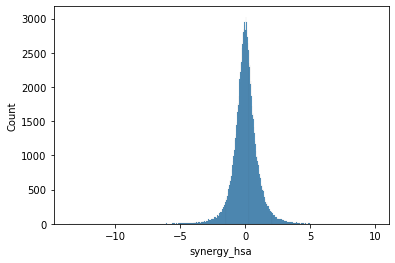

In [88]:
sns.histplot(zhsa_dc)

<AxesSubplot:xlabel='hsa', ylabel='Count'>

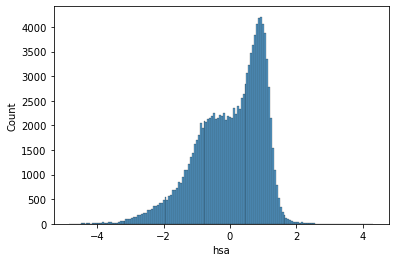

In [89]:
sns.histplot(zhsa_syn)

In [61]:
np.corrcoef(zloewe_dc, zloewe_syn)

array([[1.        , 0.25635423],
       [0.25635423, 1.        ]])

<AxesSubplot:xlabel='synergy_loewe', ylabel='Count'>

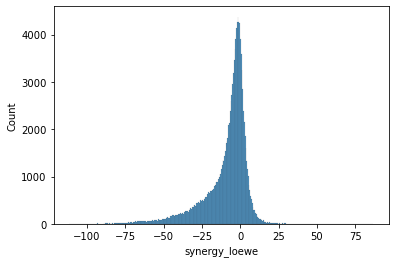

In [62]:
sns.histplot(almanac_merge.synergy_loewe)

<AxesSubplot:xlabel='loewe', ylabel='Count'>

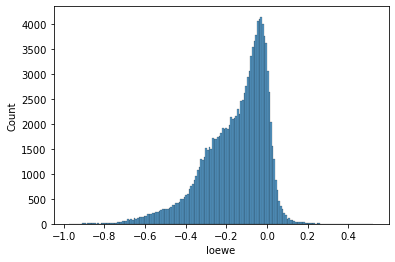

In [63]:
sns.histplot(almanac_merge.loewe)

In [64]:
pd.DataFrame(zloewe_dc)

,synergy_loewe
0,0.803086
1,0.251026
2,-0.600550
3,0.054628
4,0.468277
...,...
128909,-1.829247
128910,0.708026
128911,0.576815
128912,0.351152


In [65]:
df_syn = pd.DataFrame(zloewe_syn).rename(columns={"loewe": "zloewe"})
df_syn["DB"] = ["SynergX"] * len(zloewe_syn)
df_syn

,zloewe,DB
0,-1.145930,SynergX
1,0.759151,SynergX
2,-2.799078,SynergX
3,0.641626,SynergX
4,0.743568,SynergX
...,...,...
128909,0.098152,SynergX
128910,0.892260,SynergX
128911,0.483194,SynergX
128912,1.065627,SynergX


In [66]:
df_dc = pd.DataFrame(zloewe_dc).rename(columns={"synergy_loewe": "zloewe"})
df_dc["DB"] = ["DrugComb"] * len(zloewe_dc)
df_dc

,zloewe,DB
0,0.803086,DrugComb
1,0.251026,DrugComb
2,-0.600550,DrugComb
3,0.054628,DrugComb
4,0.468277,DrugComb
...,...,...
128909,-1.829247,DrugComb
128910,0.708026,DrugComb
128911,0.576815,DrugComb
128912,0.351152,DrugComb


In [78]:
df_cat = pd.concat([df_syn, df_dc], axis=0)
df_cat.index = range(len(df_cat))
df_cat

,zloewe,DB
0,-1.145930,SynergX
1,0.759151,SynergX
2,-2.799078,SynergX
3,0.641626,SynergX
4,0.743568,SynergX
...,...,...
257433,-1.829247,DrugComb
257434,0.708026,DrugComb
257435,0.576815,DrugComb
257436,0.351152,DrugComb


<AxesSubplot:xlabel='zloewe', ylabel='Count'>

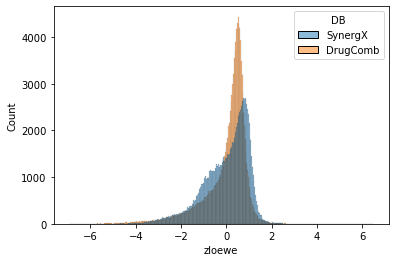

In [79]:
sns.histplot(data=df_cat, x="zloewe", hue="DB")

In [82]:
almanac_merge.triplet.tail(100)

128814    UACC62XRASPMIURGNCCH-UHFFFAOYSA-NYBBLVLTVTVSKR...
128815    UACC62XRASPMIURGNCCH-UHFFFAOYSA-NZBNZXTGUTAYRH...
128816    UACC62XRASPMIURGNCCH-UHFFFAOYSA-NZDZOTLJHXYCWB...
128817    UACC62YBBLVLTVTVSKRW-UHFFFAOYSA-NZBNZXTGUTAYRH...
128818    UACC62YBBLVLTVTVSKRW-UHFFFAOYSA-NZDZOTLJHXYCWB...
128819    UACC62ZBNZXTGUTAYRHI-UHFFFAOYSA-NZDZOTLJHXYCWB...
128820    UEJJHQNACJXSKW-UHFFFAOYSA-NUHTHHESEBZOYNR-UHFF...
128821    UEJJHQNACJXSKW-UHFFFAOYSA-NUO-31UUVWYPNAQBNQJQ...
128822    UEJJHQNACJXSKW-UHFFFAOYSA-NUO-31VSNHCAURESNICA...
128823    UEJJHQNACJXSKW-UHFFFAOYSA-NUO-31VWUXBMIQPBEWFH...
128824    UEJJHQNACJXSKW-UHFFFAOYSA-NUO-31WAEXFXRVDQXREF...
128825    UEJJHQNACJXSKW-UHFFFAOYSA-NUO-31WBXPDJSOTKVWSJ...
128826    UEJJHQNACJXSKW-UHFFFAOYSA-NUO-31WINHZLLDWRZWRT...
128827    UEJJHQNACJXSKW-UHFFFAOYSA-NUO-31WYWHKKSPHMUBEB...
128828    UEJJHQNACJXSKW-UHFFFAOYSA-NUO-31XGALLCVXEZPNRQ...
128829    UEJJHQNACJXSKW-UHFFFAOYSA-NUO-31XRASPMIURGNCCH...
128830    UEJJHQNACJXSKW-UHFFFAOYSA-NUO-